# Building Machine Learning Systems with Python - Chapter 6

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In this chapter we are discussing two methods to reduce the feature space: filters and wrappers.

## Utilities we will need

In [2]:
import os
from pathlib import Path

CHART_DIR = Path("charts")
print(CHART_DIR)
if not CHART_DIR.exists():
    CHART_DIR.mkdir()
    
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    raise Exception("Data directory %s not found" % CHART_DIR.absolute())

charts


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import scipy

DPI = 300

def save_png(name):
    fn = 'B09124_06_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(str(CHART_DIR / fn), bbox_inches="tight")

## Converting raw text into a bag of words

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1)
print(vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)


In [5]:
content = ["How to format my hard disk", 
           " Hard disk format  problems "]
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names()

['disk', 'format', 'hard', 'how', 'my', 'problems', 'to']

In [6]:
print(X.toarray())

[[1 1 1 1 1 0 1]
 [1 1 1 0 0 1 0]]


In [7]:
print(X.toarray().transpose()) 

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


## Counting words

In [8]:
TOY_DIR = DATA_DIR / "toy"
posts = [p.read_text() for p in TOY_DIR.iterdir()]
print(posts)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=1) 

['This is a toy post about machine learning. Actually, it contains not much interesting stuff.', 'Imaging databases provide storage capabilities.', 'Most imaging databases save images permanently.\n', 'Imaging databases store data.', 'Imaging databases store data. Imaging databases store data. Imaging databases store data.']


In [9]:
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape
print("#samples: %d, #features: %d" % (num_samples,  num_features))

#samples: 5, #features: 25


In [10]:
print(vectorizer.get_feature_names())

['about', 'actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'is', 'it', 'learning', 'machine', 'most', 'much', 'not', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'this', 'toy']


In [11]:
new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post]) 
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


In [12]:
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [13]:
type(new_post_vec)

scipy.sparse.csr.csr_matrix

In [14]:
def dist_raw(v1, v2): 
    delta = v1-v2
    return scipy.linalg.norm(delta.toarray()) 

In [15]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = float('inf')
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post: 
            continue 
        post_vec = X.getrow(i) 
        d = dist_func(post_vec, new_vec) 
        print("=== Post %i with dist=%.2f:\n    '%s'" % \
              (i, d, post)) 
        if d < best_dist: 
            best_dist = d 
            best_i = i
    print("\n==> Best post is %i with dist=%.2f" % \
          (best_i, best_dist))

In [16]:
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=1.41:
    'Imaging databases store data.'
=== Post 4 with dist=5.10:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=1.41


In [17]:
print(X_train.getrow(3).toarray())

[[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [18]:
print(X_train.getrow(4).toarray())

[[0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]]


## Normalizing word count vectors

In [19]:
def dist_norm(v1, v2): 
    v1_normalized = v1 / scipy.linalg.norm(v1.toarray()) 
    v2_normalized = v2 / scipy.linalg.norm(v2.toarray()) 
    delta = v1_normalized - v2_normalized  
    return scipy.linalg.norm(delta.toarray()) 

best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Removing less important words

In [20]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')
print(sorted(vect_engl.get_stop_words())[0:500])
print(len(sorted(vect_engl.get_stop_words())[0:500]))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give

In [21]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print("#samples: %d, #features: %d" % (num_samples_engl,  num_features_engl))
print(vect_engl.get_feature_names())

#samples: 5, #features: 18
['actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'learning', 'machine', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'toy']


In [22]:
new_post_vec_engl = vect_engl.transform([new_post]) 
print(new_post_vec_engl)

  (0, 4)	1
  (0, 6)	1


In [23]:
best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 3 with dist=0.77


## Stemming

In [24]:
import nltk.stem

s = nltk.stem.SnowballStemmer('english')
print(s.stem("graphics"))
print(s.stem("imaging"))
print(s.stem("image"))
print(s.stem("imagination"))
print(s.stem("imagine"))
print(s.stem("buys"))
print(s.stem("buying"))
print(s.stem("bought"))

graphic
imag
imag
imagin
imagin
buy
buy
bought


In [25]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer): 
    def build_analyzer(self): 
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in  analyzer(doc))

vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')        
print(vect_engl_stem)

StemmedCountVectorizer(analyzer='word', binary=False, decode_error='strict',
                       dtype=<class 'numpy.int64'>, encoding='utf-8',
                       input='content', lowercase=True, max_df=1.0,
                       max_features=None, min_df=1, ngram_range=(1, 1),
                       preprocessor=None, stop_words='english',
                       strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                       tokenizer=None, vocabulary=None)


In [26]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print("#samples: %d, #features: %d" % (num_samples_engl_stem,  num_features_engl_stem))
print(vect_engl_stem.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


In [27]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
print(new_post_vec_engl_stem)

best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

  (0, 4)	1
  (0, 5)	1
=== Post 0 with dist=1.41:
    'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86:
    'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63:
    'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77:
    'Imaging databases store data.'
=== Post 4 with dist=0.77:
    'Imaging databases store data. Imaging databases store data. Imaging databases store data.'

==> Best post is 2 with dist=0.63


## Stop words on steroids using TFIDF

In [28]:
def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print("term='%s'   doc=%-17s tf=%.2f   idf=%.2f"%\
          (term, doc, tf, idf))
    return tf_idf

# defining some documents
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]

# defining some copora
D = [a, abb, abc]

print("=> tfidf=%.2f" % tfidf("a", a, D))
print("=> tfidf=%.2f" % tfidf("a", abb, D))
print("=> tfidf=%.2f" % tfidf("a", abc, D))
print("=> tfidf=%.2f" % tfidf("b", abb, D))
print("=> tfidf=%.2f" % tfidf("b", abc, D))
print("=> tfidf=%.2f" % tfidf("c", abc, D))

term='a'   doc=['a']             tf=1.00   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'b']   tf=0.33   idf=0.00
=> tfidf=0.00
term='a'   doc=['a', 'b', 'c']   tf=0.33   idf=0.00
=> tfidf=0.00
term='b'   doc=['a', 'b', 'b']   tf=0.67   idf=0.41
=> tfidf=0.27
term='b'   doc=['a', 'b', 'c']   tf=0.33   idf=0.41
=> tfidf=0.14
term='c'   doc=['a', 'b', 'c']   tf=0.33   idf=1.10
=> tfidf=0.37


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(#min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
print(vect_tfidf)

StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                       dtype=<class 'numpy.float64'>, encoding='utf-8',
                       input='content', lowercase=True, max_df=1.0,
                       max_features=None, min_df=1, ngram_range=(1, 1),
                       norm='l2', preprocessor=None, smooth_idf=True,
                       stop_words='english', strip_accents=None,
                       sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                       tokenizer=None, use_idf=True, vocabulary=None)


In [30]:
X_train_tfidf = vect_tfidf.fit_transform(posts)
num_samples_tfidf, num_features_tfidf = X_train_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(vect_tfidf.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


## K-means Clustering

[ 0.23748632  0.29155998 -0.02042941  0.54604062  0.03098466  0.1737379
  0.37543221  0.11320679  0.14130717  0.16364886  0.38271811  0.6438312
  0.30623091  0.13231118  0.38085875  0.21057605  0.29713043  0.47625018
  0.18781936  0.30135379]


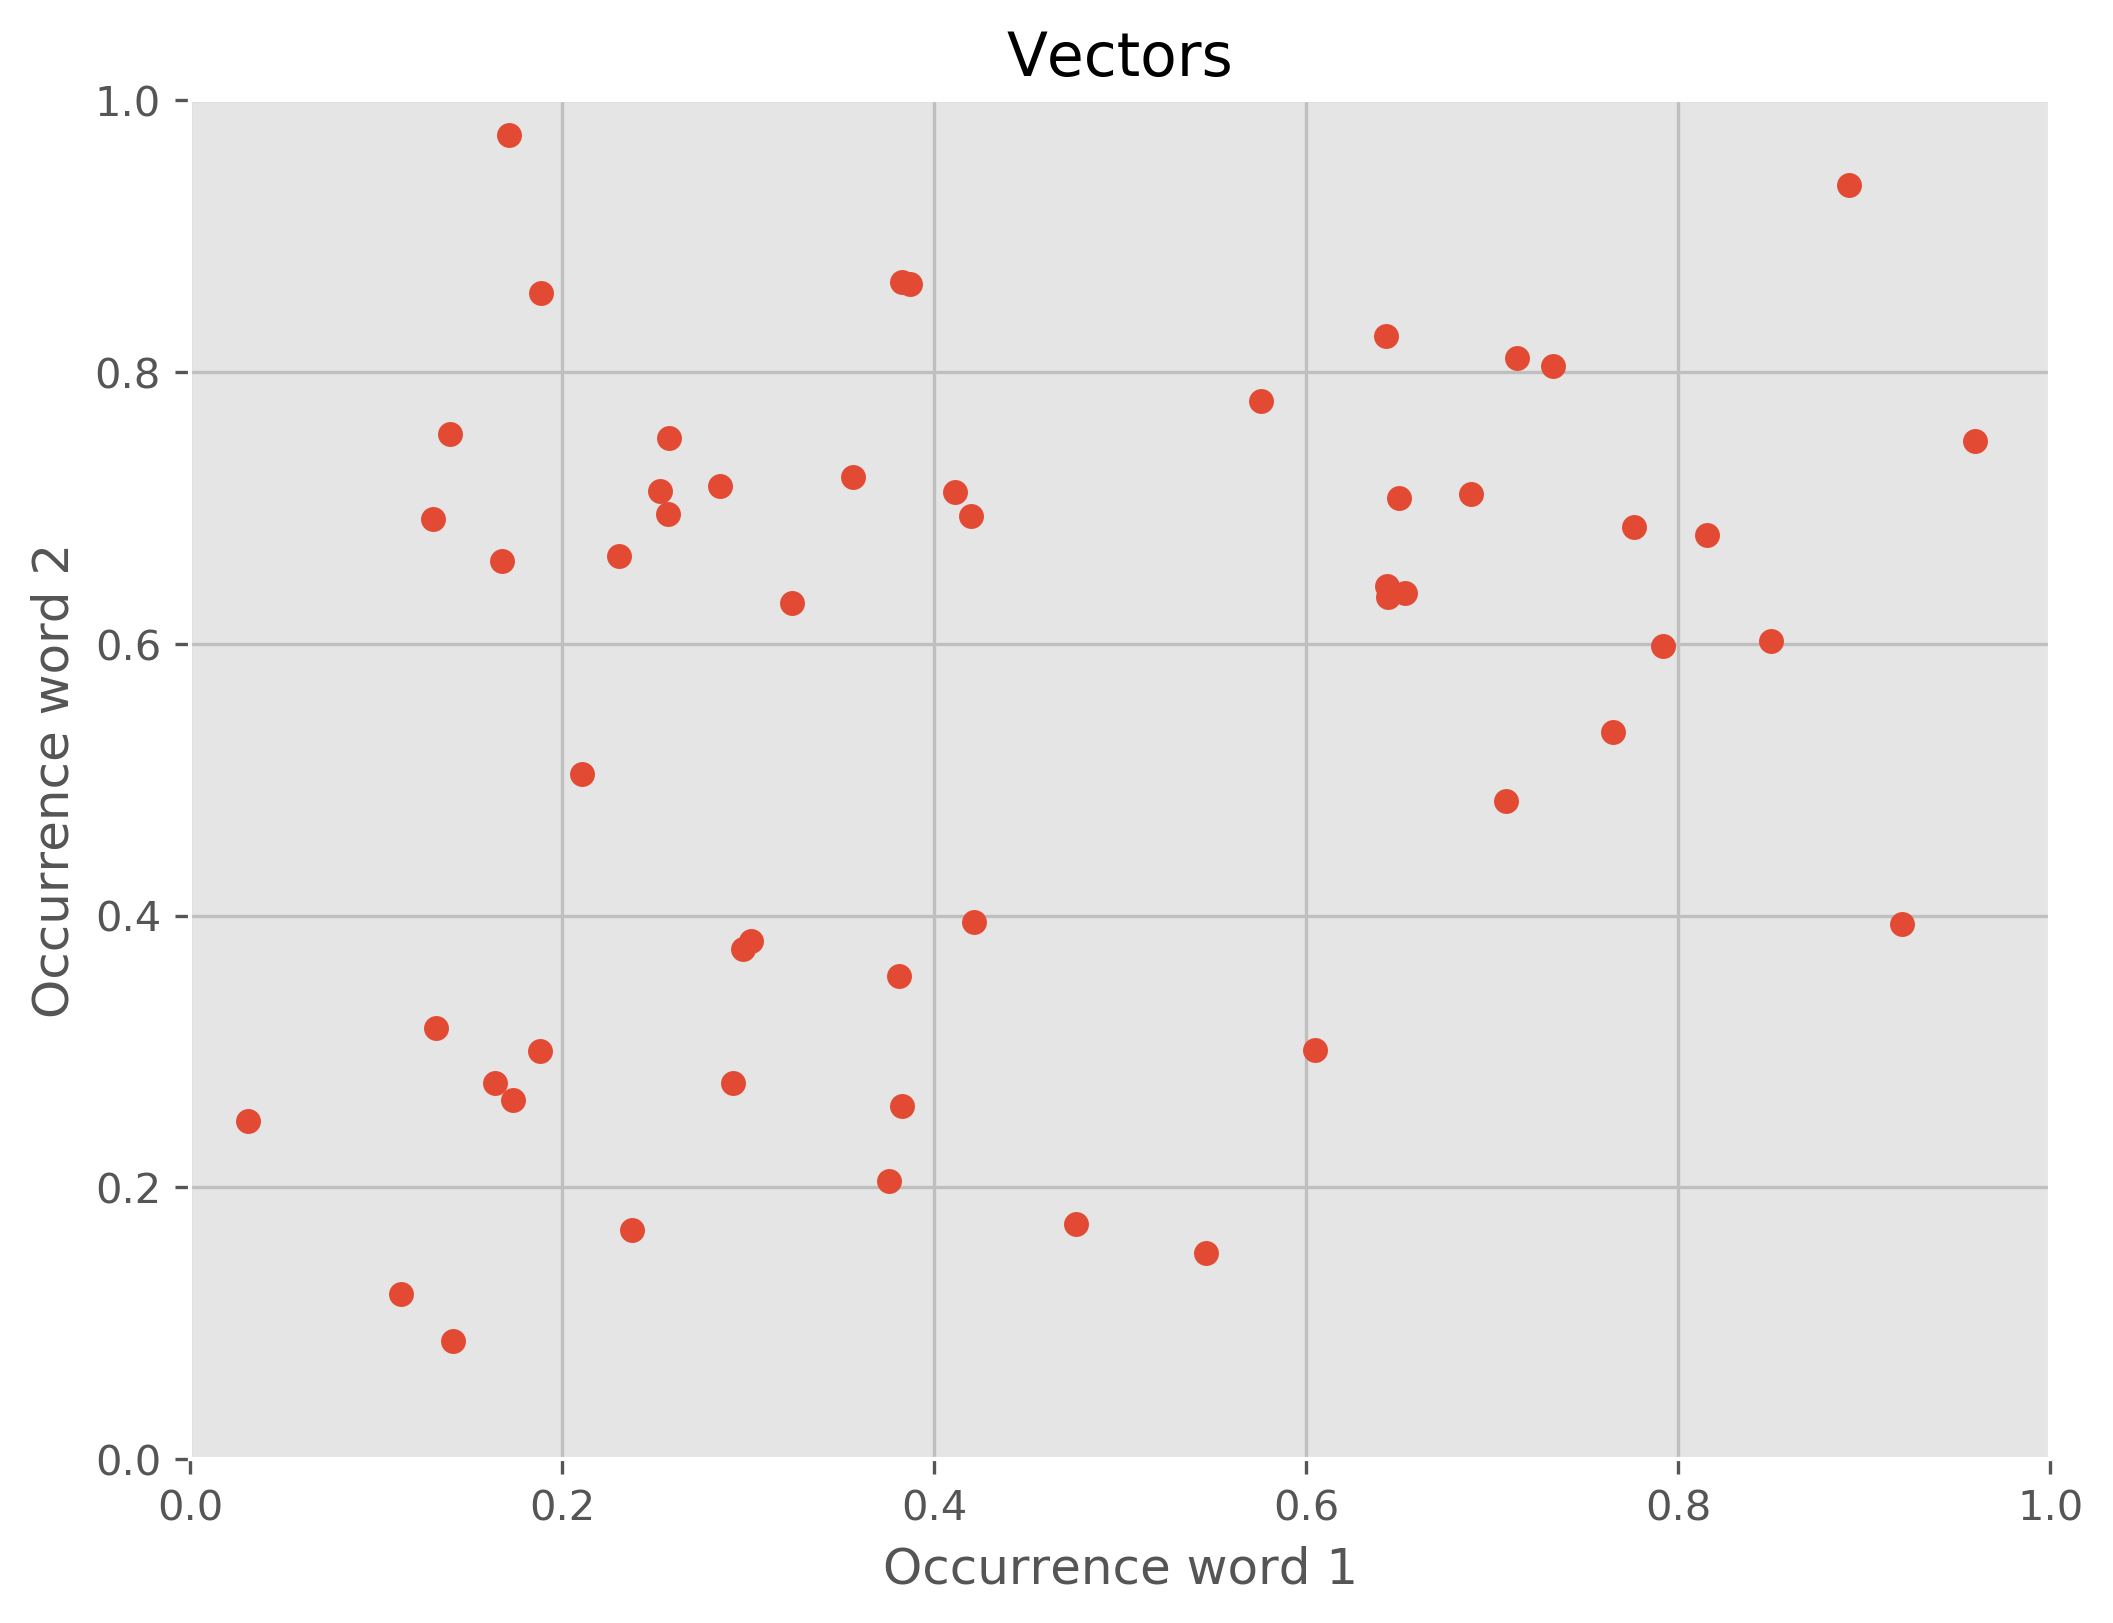

In [42]:
from sklearn.cluster import KMeans

seed = 2
np.random.seed(seed)  # to reproduce the data later on

num_clusters = 3


def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)
print(xw1)
yw1 = scipy.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = scipy.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = scipy.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = scipy.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")
save_png("01_clustering_data")

### Clustering after 1st iteration

[[0.    0.001 0.002 ... 0.997 0.998 0.999]
 [0.    0.001 0.002 ... 0.997 0.998 0.999]
 [0.    0.001 0.002 ... 0.997 0.998 0.999]
 ...
 [0.    0.001 0.002 ... 0.997 0.998 0.999]
 [0.    0.001 0.002 ... 0.997 0.998 0.999]
 [0.    0.001 0.002 ... 0.997 0.998 0.999]]
<class 'numpy.ndarray'>
-------------------------------
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 ...
 [0.997 0.997 0.997 ... 0.997 0.997 0.997]
 [0.998 0.998 0.998 ... 0.998 0.998 0.998]
 [0.999 0.999 0.999 ... 0.999 0.999 0.999]]
(1000, 1000)
[0.    0.001 0.002 ... 0.997 0.998 0.999]
[[0.    0.   ]
 [0.001 0.   ]
 [0.002 0.   ]
 ...
 [0.997 0.999]
 [0.998 0.999]
 [0.999 0.999]]
(1000000, 2)
--zz1--------------------------
[1 1 1 ... 0 0 0]
(1000000,)
--ZZ1--------------------------
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]
(1000, 1000)
--Z-----------------------

C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


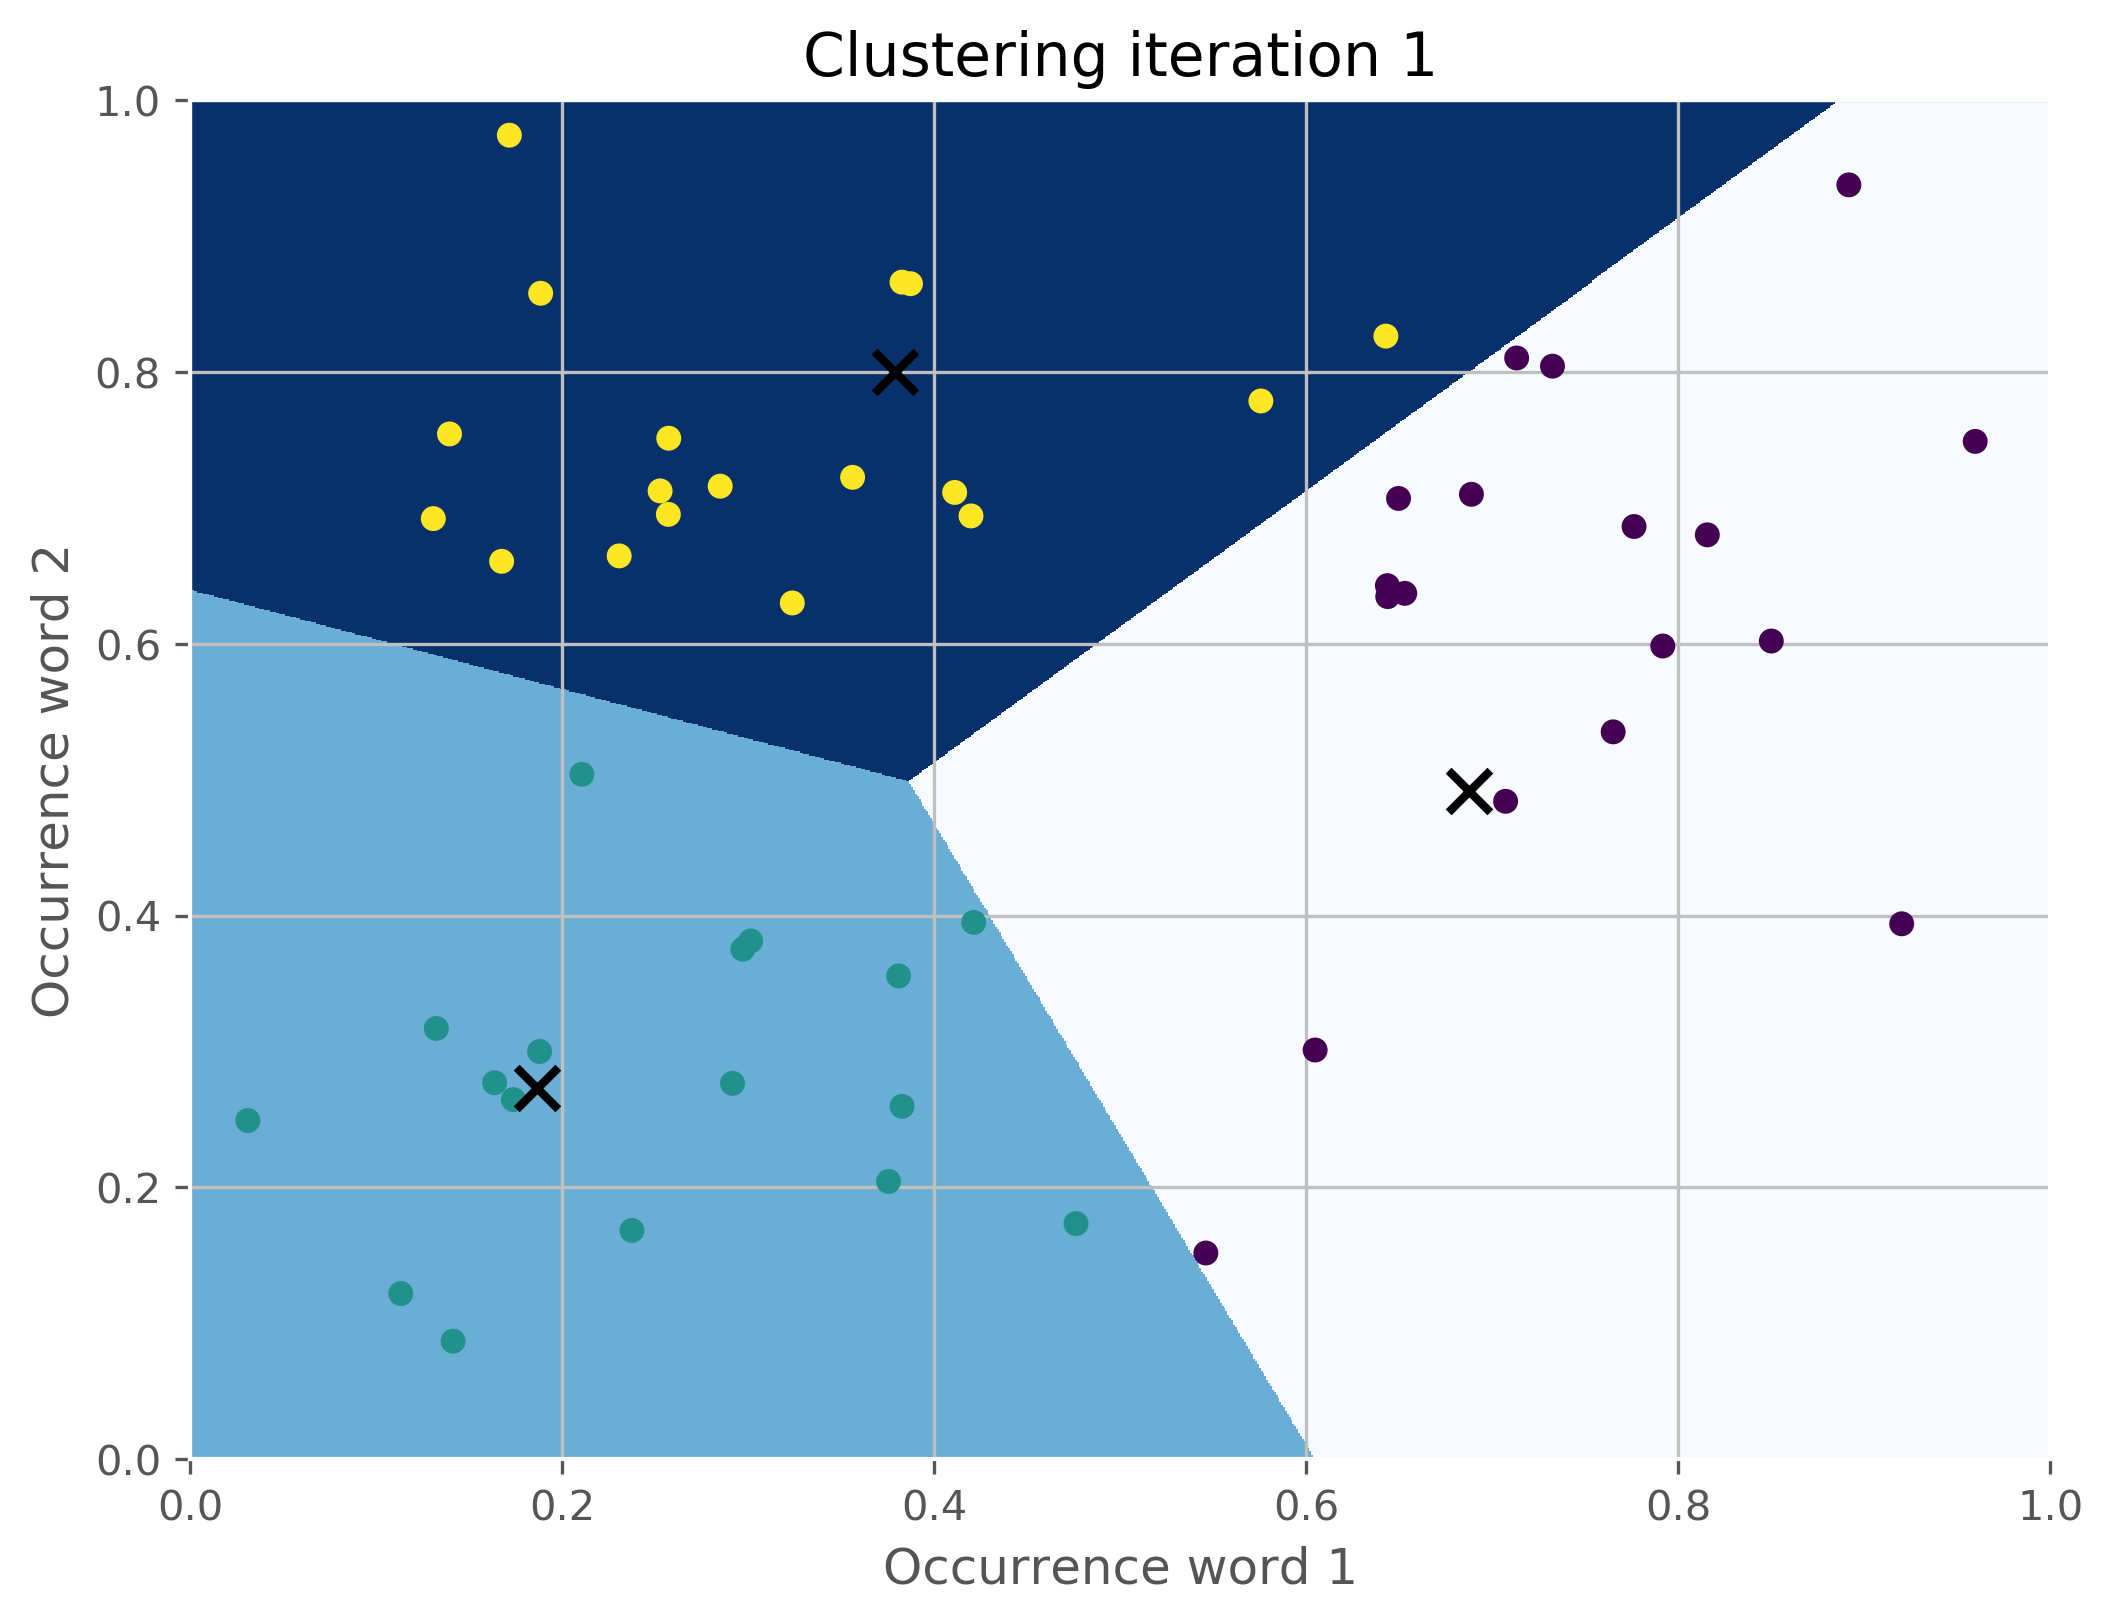

In [65]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))
print(mx)
print(type(mx))
print("-------------------------------")
print(my)
print(mx.shape)
print(mx.ravel())

km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=1,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

zz1 = np.c_[mx.ravel(), my.ravel()]
print(zz1)
print(zz1.shape)
print("--zz1--------------------------")
ZZ1 = km.predict(zz1)
print(ZZ1)
print(ZZ1.shape)
print("--ZZ1--------------------------")
Z = ZZ1.reshape(mx.shape)
print(Z)
print(Z.shape)
print("--Z----------------------------")

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("02_clustering_iteration_1")

### Clustering after 2nd iteration

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3.746456379702266
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.835476341923971


C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


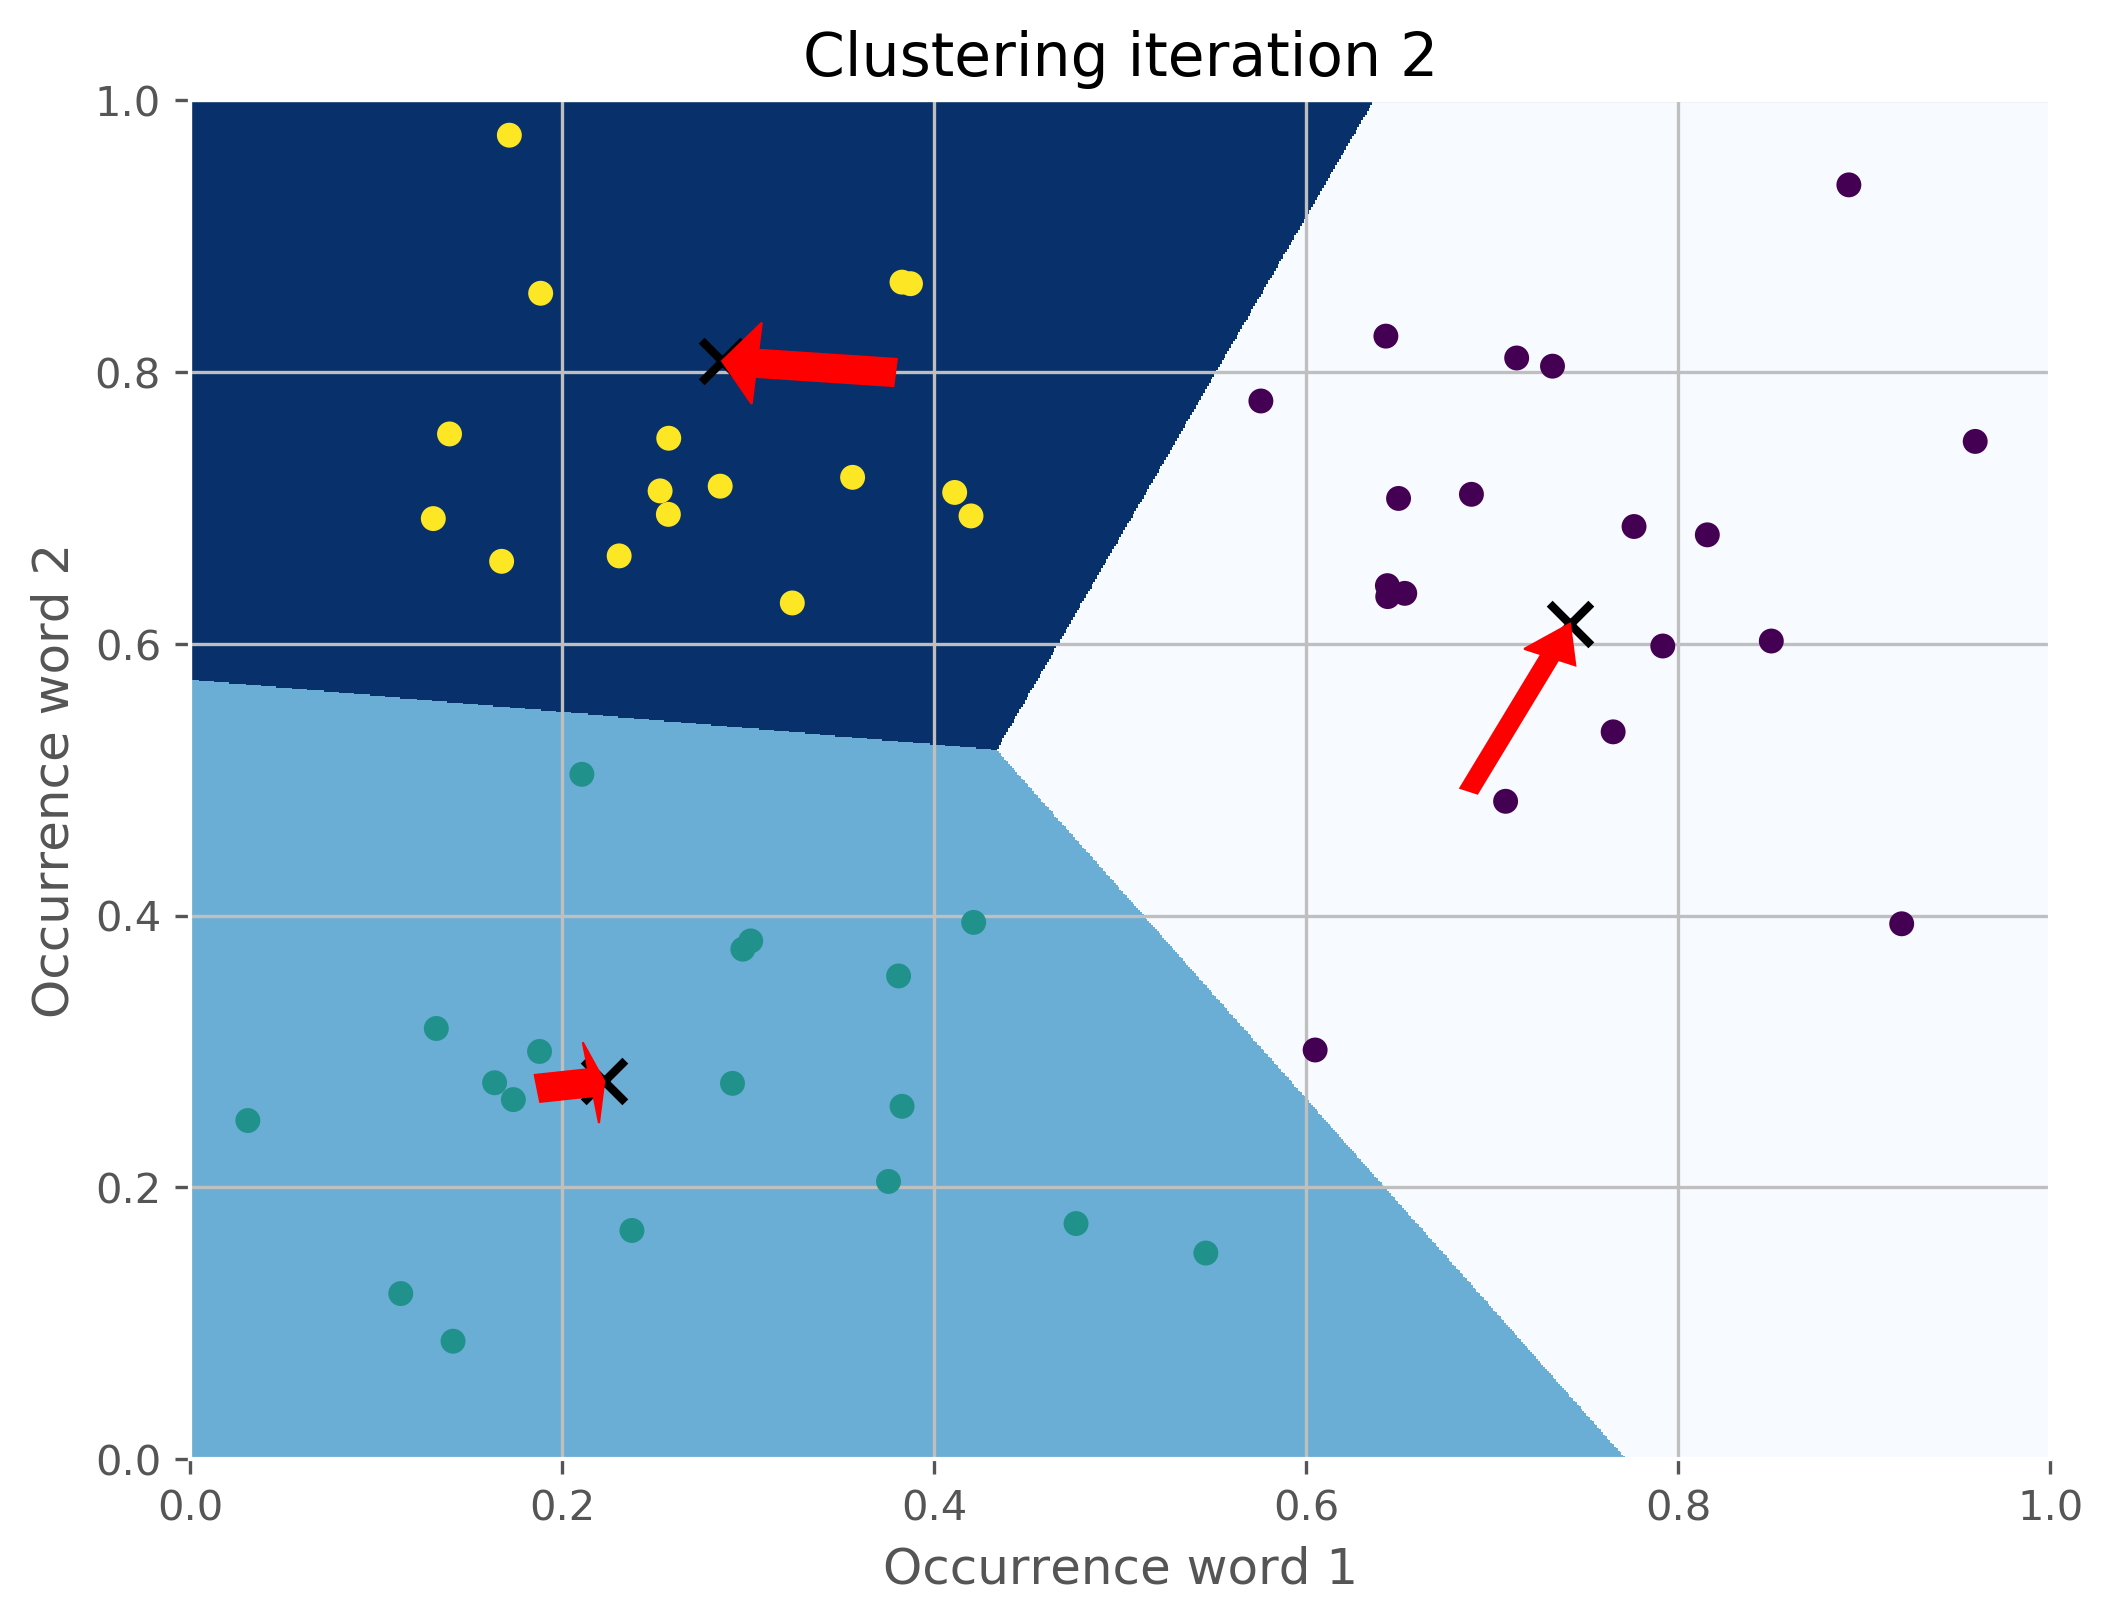

In [71]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=2,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest',
           extent=(mx.min(), mx.max(), my.min(), my.max()),
           cmap=plt.cm.Blues,
           aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.05, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))

save_png("03_clustering_iteration_2")

### Final clustering
We iterate at max 10 iterations, but will converge earlier.

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3.746456379702266
start iteration
done sorting
end inner loop
Iteration 1, inertia 2.835476341923971
start iteration
done sorting
end inner loop
Iteration 2, inertia 2.536046256119067
start iteration
done sorting
end inner loop
Iteration 3, inertia 2.447223016211801
start iteration
done sorting
end inner loop
Iteration 4, inertia 2.447223016211801
center shift 0.000000e+00 within tolerance 7.366762e-06


C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


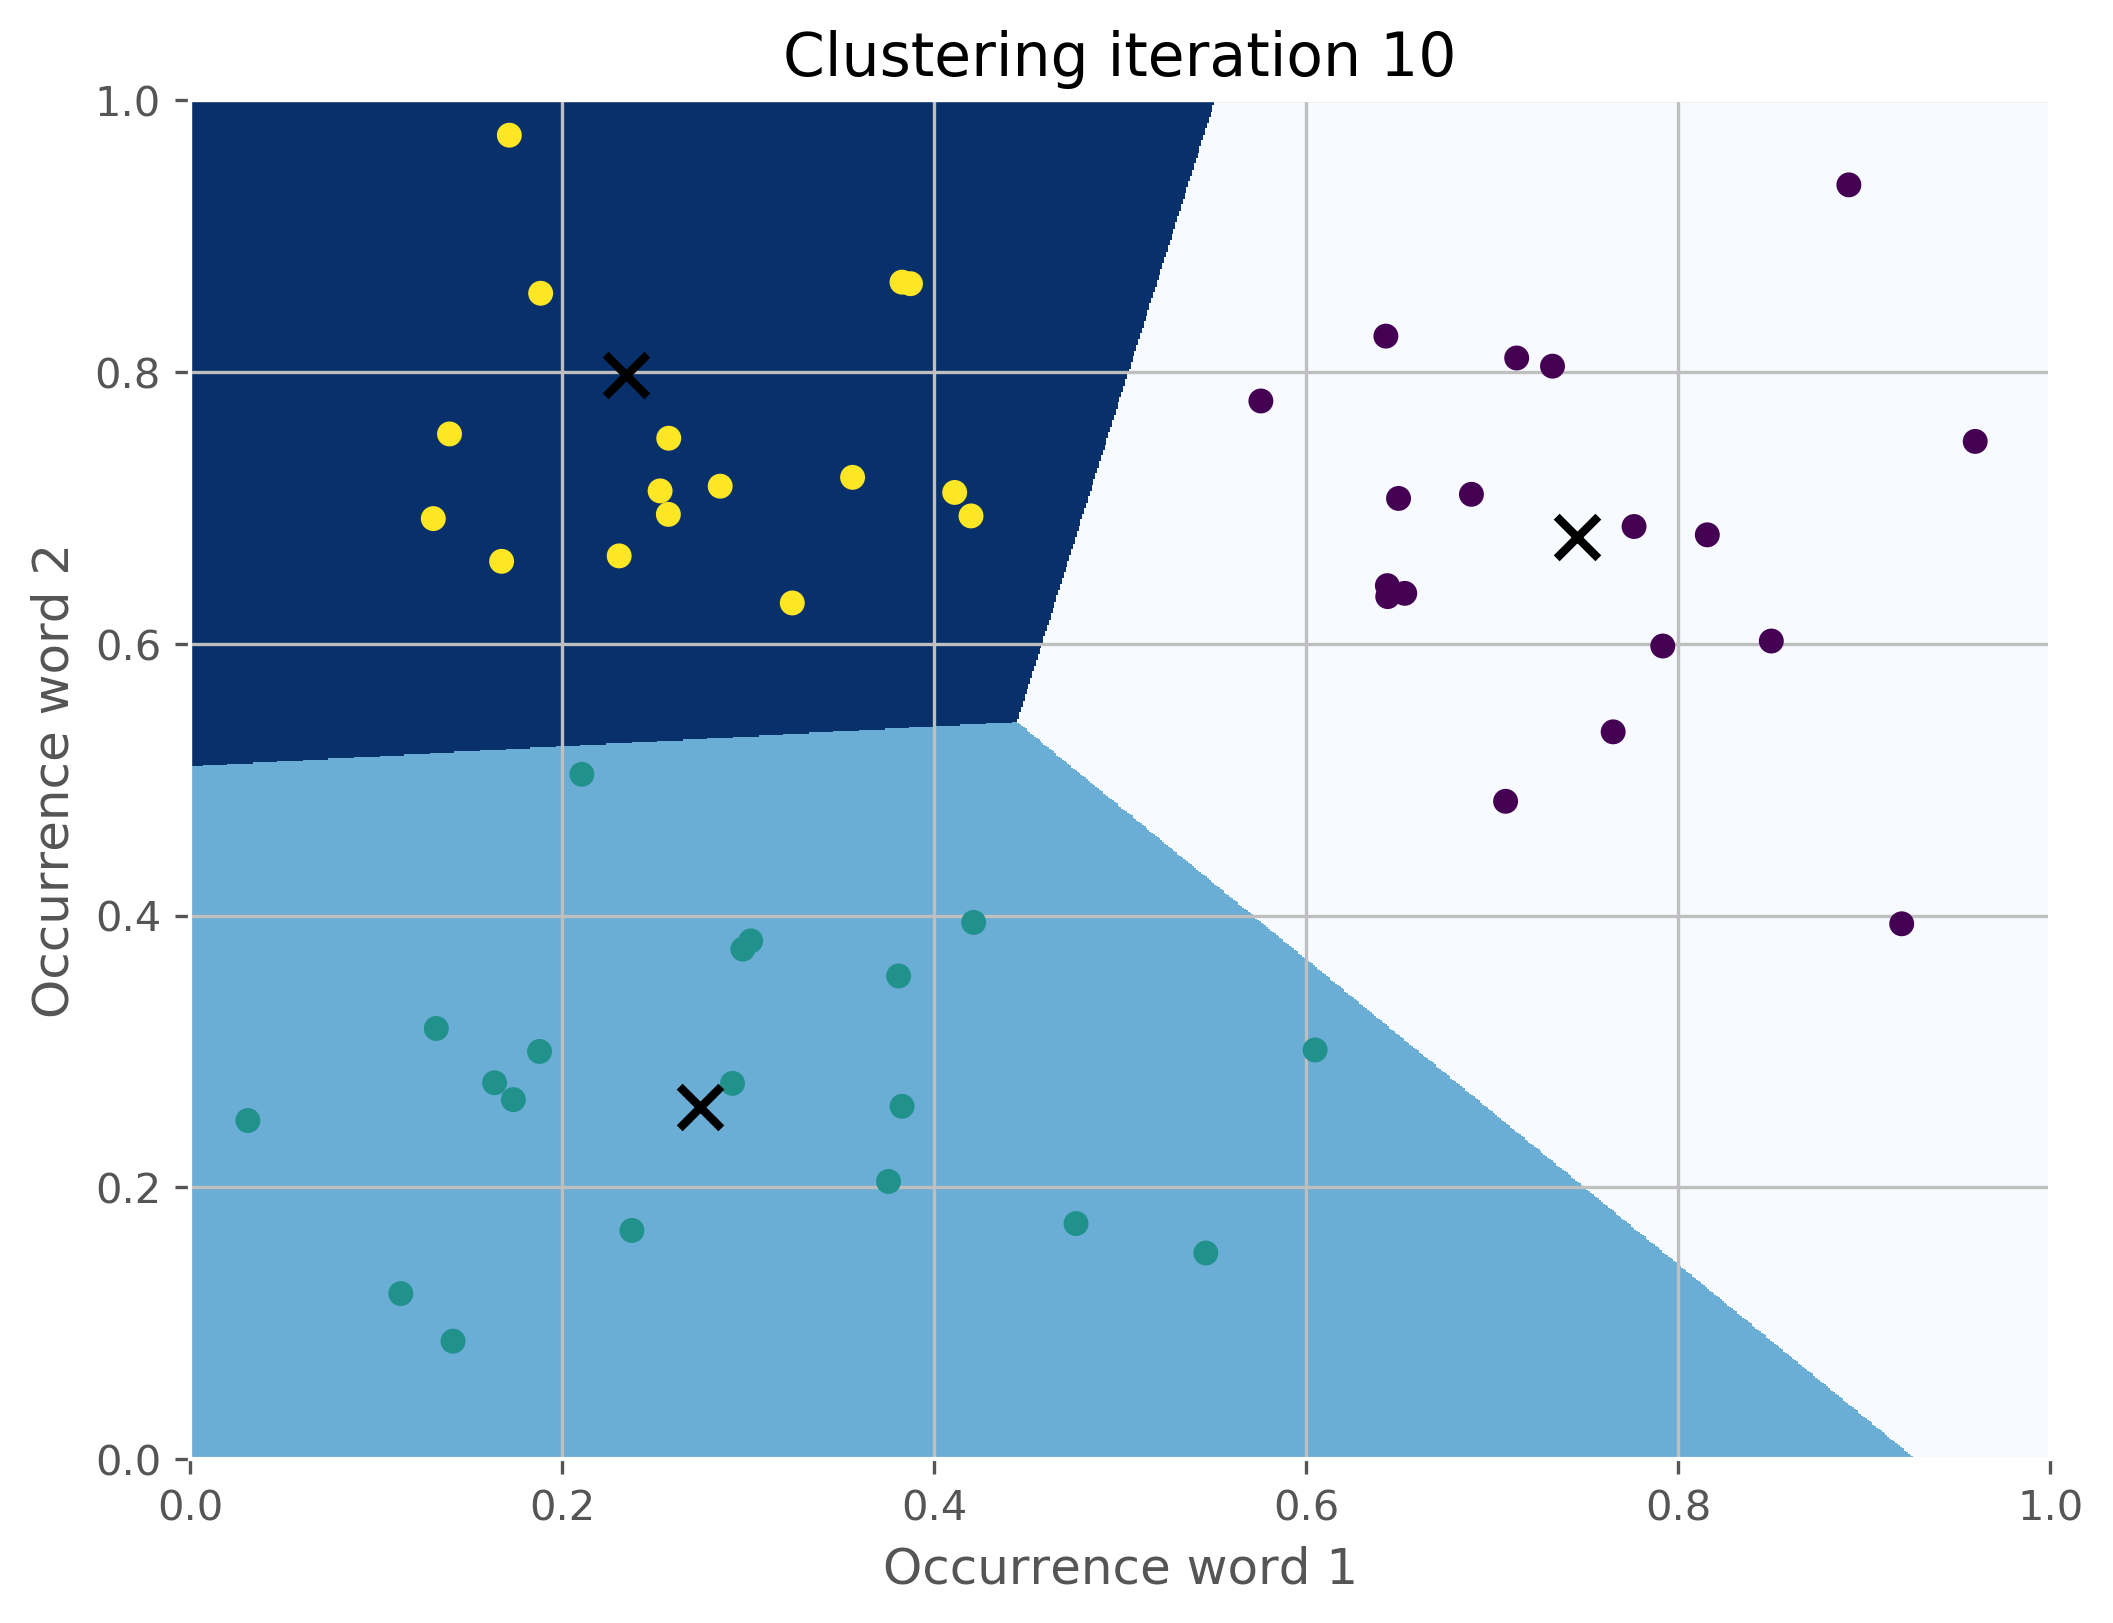

In [35]:
# 10 iterations ####################
km = KMeans(init='random', n_clusters=num_clusters, verbose=1,
            n_init=1, max_iter=10,
            random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(Z, interpolation='nearest',
             extent=(mx.min(), mx.max(), my.min(), my.max()),
             cmap=plt.cm.Blues,
             aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
              marker='x', linewidth=2, s=100, color='black')
save_png("04_clustering_iteration_final")

## Testing our idea on real data

In [72]:
import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset='all') 
print(len(all_data.filenames))
print(all_data.target_names)
print(len(all_data.target_names))

18846
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
20


In [73]:
train_data = sklearn.datasets.fetch_20newsgroups(subset="train")
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test')
print(len(test_data.filenames))

11314
7532


In [77]:
print(type(train_data.filenames))
print(type(train_data.target_names))

<class 'numpy.ndarray'>
<class 'list'>


In [76]:
print(train_data.filenames)

['C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\rec.autos\\102994'
 'C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.sys.mac.hardware\\51861'
 'C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.sys.mac.hardware\\51879'
 ...
 'C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.sys.ibm.pc.hardware\\60695'
 'C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\comp.graphics\\38319'
 'C:\\Users\\gkanavenko\\scikit_learn_data\\20news_home\\20news-bydate-train\\rec.motorcycles\\104440']


In [78]:
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
          'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']

train_data = sklearn.datasets.fetch_20newsgroups(subset="train", categories=groups)
print(len(train_data.filenames))

test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(test_data.filenames))

3529
2349


In [90]:
print(type(train_data.data))
print(type(train_data.filenames))
print(type(train_data.target_names))

print(len(train_data.data))
print(len(train_data.filenames))
print(len(train_data.target_names))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
3529
3529
6


In [97]:
print(train_data.data[0:1])

['From: maverick@wpi.WPI.EDU (T. Giaquinto)\nSubject: General Information Request\nOrganization: Worcester Polytechnic Institute, Worcester, MA 01609-2280\nLines: 11\nNNTP-Posting-Host: wpi.wpi.edu\n\n\n\tI am looking for any information about the space program.\nThis includes NASA, the shuttles, history, anything!  I would like to\nknow if anyone could suggest books, periodicals, even ftp sites for a\nnovice who is interested in the space program.\n\n\n\n\t\t\t\t\tTodd Giaquinto\n\t\t\t\t\tmaverick@wpi.WPI.EDU\n\t\t\t\t\t\n']


## Clustering posts

In [79]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                    stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)

num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 3529, #features: 4712


In [100]:
vectorizer.get_feature_names()

['00',
 '000',
 '01',
 '02',
 '03',
 '030',
 '04',
 '040',
 '0400',
 '05',
 '06',
 '07',
 '08',
 '09',
 '0_',
 '0a',
 '0b',
 '0d',
 '0h',
 '0i',
 '0l',
 '0m',
 '0p',
 '0q',
 '0qax',
 '0t',
 '0u',
 '0w',
 '10',
 '100',
 '1000',
 '101',
 '102',
 '1024',
 '1024x768',
 '1024x768x256',
 '104',
 '105',
 '106',
 '107',
 '109',
 '10mb',
 '11',
 '110',
 '111',
 '113',
 '115',
 '12',
 '120',
 '1200',
 '121',
 '122',
 '123',
 '125',
 '127',
 '128',
 '1280',
 '1280x1024',
 '129',
 '12mb',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '14',
 '140',
 '141',
 '142',
 '144',
 '145',
 '146',
 '147',
 '149',
 '15',
 '150',
 '152',
 '155',
 '16',
 '160',
 '16550',
 '16bit',
 '16mb',
 '17',
 '170',
 '175',
 '18',
 '180',
 '18084tm',
 '189',
 '19',
 '192',
 '1958',
 '1970',
 '1973',
 '1980',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '199',
 '1990',
 '1991',
 '1992',
 '1993',
 '1993apr12',
 '1993apr14',
 '1993apr15',
 '1993apr16',
 '1993apr17',
 '1993a

In [101]:
num_clusters = 50  # np.unique(labels).shape[0]

km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
clustered = km.fit(vectorized)

Initialization complete
Iteration  0, inertia 5686.053
Iteration  1, inertia 3164.888
Iteration  2, inertia 3132.208
Iteration  3, inertia 3111.713
Iteration  4, inertia 3098.584
Iteration  5, inertia 3092.191
Iteration  6, inertia 3087.277
Iteration  7, inertia 3084.100
Iteration  8, inertia 3082.800
Iteration  9, inertia 3082.234
Iteration 10, inertia 3081.949
Iteration 11, inertia 3081.843
Iteration 12, inertia 3081.791
Iteration 13, inertia 3081.752
Iteration 14, inertia 3081.660
Iteration 15, inertia 3081.617
Iteration 16, inertia 3081.589
Iteration 17, inertia 3081.571
Converged at iteration 17: center shift 0.000000e+00 within tolerance 2.069005e-08


In [102]:
print("km.labels_=%s" % km.labels_)
print("km.labels_.shape=%s" % km.labels_.shape)

km.labels_=[48 23 31 ...  6  2 22]
km.labels_.shape=3529


In [103]:
new_post = '''\
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
'''

new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

similar_indices = (km.labels_ == new_post_label).nonzero()[0]

similar = []
for i in similar_indices:
    dist = scipy.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [104]:
print(new_post_label)

9


In [105]:
print(similar_indices)

[  69  152  157  167  201  225  228  233  359  463  479  520  552  580
  622  676  779  882  884  917  939 1114 1253 1286 1486 1531 1752 1806
 1809 1986 2061 2249 2351 2412 2447 2493 2499 2510 2512 2600 2730 2800
 2889 3080 3111 3145 3146 3199 3202 3278 3285 3297 3310 3350 3437 3458]


In [106]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[len(similar) // 10]
show_at_3 = similar[len(similar) // 2]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

Count similar: 56
=== #1 ===
(1.0378441731334072, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel            

In [107]:
post_group = zip(train_data.data, train_data.target)

# Create a list of tuples that can be sorted by
# the length of the posts
all = [(len(post[0]), post[0], train_data.target_names[post[1]])
       for post in post_group]
graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


In [108]:
noise_post = graphics[5][1]

analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


In [109]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [110]:
for term in sorted(useful):
    print('IDF(%-10s) = %.2f' % (term, vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac        ) = 3.51
IDF(birmingham) = 6.77
IDF(host      ) = 1.74
IDF(kingdom   ) = 6.68
IDF(nntp      ) = 1.77
IDF(sorri     ) = 4.14
IDF(test      ) = 3.83
IDF(uk        ) = 3.70
IDF(unit      ) = 4.42
IDF(univers   ) = 1.91
